# Comparação de Algoritmos de Aprendizado Supervisionado em Problemas de Classificação

- Gabriel Peres de Souza
- João Carlos dos Santos Correia
- Rodrigo Macedo Silva Junior

## Importando bibliotecas

In [1]:
# Importação das bibliotecas
import os, json, math, pprint, pathlib
import numpy as np
import pandas as pd
from IPython.display import display, Image, Markdown
# módulos do projeto
import importlib, sys
sys.path.append('/data')  # garante import local
from algorithms import sgd_logreg
from algorithms import knn_model
from algorithms import compare_plots
print("Versões:", {"pandas": pd.__version__})


Versões: {'pandas': '2.3.3'}


## Carregamento dos Dados
O conjunto de dados utilizado neste estudo é o **"Dodgers Loop Sensor"**, obtido do repositório da UCI Machine Learning. O objetivo central é a classificação de dias em que ocorreram jogos de beisebol do time Dodgers, em Los Angeles, com base em dados de um sensor de contagem de veículos.

Os dados foram coletados por um sensor de laço indutivo em uma rampa de acesso para uma rodovia, estrategicamente posicionada para capturar um sinal de tráfego sutil, que se manifesta principalmente como um aumento no fluxo de veículos ao final das partidas. As medições foram agregadas a cada 5 minutos ao longo de 25 semanas, resultando em um dataset rico para a análise de anomalias no fluxo de tráfego.

In [2]:
# Carregamento e descrição da base de dados
data_dir = pathlib.Path("data")
data_dir.mkdir(exist_ok=True)

processed_csv = data_dir / "Dodgers_processed.csv"
raw_data = data_dir / "Dodgers_data.csv"
raw_events = data_dir / "Dodgers_events.csv"

if not processed_csv.exists():
    if raw_data.exists() and raw_events.exists():
        # Executa o pré-processamento para gerar o CSV final
        %run /data/process_data.py
    else:
        print("⚠️ Arquivos brutos não encontrados em ./data/.")
        print("Esperado: data/Dodgers_data.csv e data/Dodgers_events.csv")
        print("Cole-os em data/ e re-execute esta célula.")

if processed_csv.exists():
    df = pd.read_csv(processed_csv)
    display(Markdown(f"**Amostra do dataset processado ({len(df)} linhas):**"))
    display(df.head(10))
    # Distribuição da variável alvo
    display(Markdown("**Distribuição da coluna `Event` (alvo):**"))
    display(df['Event'].value_counts().rename({0:'Não-evento',1:'Evento'}).to_frame('contagem'))


**Amostra do dataset processado (50400 linhas):**

,Date,Time,Count,Event
0,4/10/2005,0:00,33,0
1,4/10/2005,0:05,33,0
2,4/10/2005,0:10,33,0
3,4/10/2005,0:15,33,0
4,4/10/2005,0:20,33,0
5,4/10/2005,0:25,33,0
6,4/10/2005,0:30,33,0
7,4/10/2005,0:35,33,0
8,4/10/2005,0:40,33,0
9,4/10/2005,0:45,33,0


**Distribuição da coluna `Event` (alvo):**

,contagem
Event,
Não-evento,47560
Evento,2840


## Pré-processamento dos dados (se precisar)

In [3]:
# Checagens rápidas de qualidade dos dados
if 'df' in globals():
    missing = df.isna().sum()
    display(Markdown("**Valores ausentes por coluna:**"))
    display(missing[missing>0].to_frame('NA'))
    display(Markdown("**Estatísticas descritivas básicas:**"))
    display(df.describe(include='all'))


**Valores ausentes por coluna:**

,NA


**Estatísticas descritivas básicas:**

,Date,Time,Count,Event
count,50400,50400,50400.000000,50400.000000
unique,175,288,NaN,NaN
top,4/10/2005,0:00,NaN,NaN
freq,288,175,NaN,NaN
mean,NaN,NaN,21.439444,0.056349
std,NaN,NaN,13.250207,0.230597
min,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,9.000000,0.000000
50%,NaN,NaN,22.000000,0.000000
75%,NaN,NaN,32.000000,0.000000


## Implementação dos algoritmos escolhidos
Para este problema de classificação, foram selecionados dois algoritmos de aprendizado supervisionado com abordagens distintas para a criação de fronteiras de decisão: a Regressão Logística, implementada com o otimizador Gradiente Descendente Estocástico (SGD), e o k-Vizinhos Mais Próximos (k-NN). O objetivo é comparar seus desempenhos e determinar qual modelo é mais eficaz para detectar os eventos de interesse.

In [4]:
# Descrição dos Algoritmos (sumário rápido)
print("Modelos utilizados:")
print("- Regressão Logística via SGD (sgd_logreg.evaluate_sgd)")
print("- k-Nearest Neighbors (knn_model.evaluate_knn)")


Modelos utilizados:
- Regressão Logística via SGD (sgd_logreg.evaluate_sgd)
- k-Nearest Neighbors (knn_model.evaluate_knn)


## 1º Algoritmo

### Regressão Logística (treinada com Gradiente Descendente Estocástico)

A Regressão Logística é um modelo linear que calcula diretamente a probabilidade de uma instância pertencer à classe positiva. Isso é feito através da função sigmoide, que mapeia qualquer valor real para o intervalo entre 0 e 1.

Neste trabalho, os parâmetros do modelo são otimizados utilizando o **Gradiente Descendente Estocástico (SGD)**, um método eficiente para minimizar a função de perda logística (entropia cruzada).

In [5]:
# Treino/Avaliação: Regressão Logística (SGD)
sgd_json_path = "data/sgd_results.json"
if not pathlib.Path(sgd_json_path).exists():
    if not (pathlib.Path("data/Dodgers_processed.csv").exists()):
        raise FileNotFoundError("data/Dodgers_processed.csv não encontrado. Gere-o na célula de dados.")
    res_sgd = sgd_logreg.evaluate_sgd(
        csv_path="data/Dodgers_processed.csv",
        cv_splits=10,
        random_state=42,
        output_prefix="data/sgd"
    )
    print("Resultados SGD salvos em", sgd_json_path)
else:
    with open(sgd_json_path, "r", encoding="utf-8") as f:
        res_sgd = json.load(f)
    print("Resultados SGD carregados de", sgd_json_path)
# mostra métricas médias de CV se disponíveis
if "metricas_media_cv" in res_sgd:
    display(pd.DataFrame(res_sgd["metricas_media_cv"], index=["SGD"]).T)


Resultados SGD carregados de data/sgd_results.json


,SGD
acurácia,0.692599
precisão,0.140730
revocação,0.871831
f1,0.242311
roc_auc,0.814478


## 2º Algorimo

### k-Vizinhos Mais Próximos (k-NN)

O k-NN é um algoritmo de aprendizado baseado em instâncias, também conhecido como "lazy learner", pois não constrói um modelo explícito durante o treinamento.

Para classificar uma nova amostra, o k-NN calcula sua distância em relação a todas as amostras de treino. Em seguida, ele seleciona os *k* vizinhos mais próximos e a classificação é definida pela classe majoritária entre eles (votação). A eficácia do algoritmo depende criticamente da escolha do hiperparâmetro *k* e da métrica de distância utilizada (neste estudo, a distância Euclidiana).

In [6]:
# Treino/Avaliação: k-Nearest Neighbors (KNN)
knn_json_path = "data/knn_results.json"
if not pathlib.Path(knn_json_path).exists():
    if not (pathlib.Path("data/Dodgers_processed.csv").exists()):
        raise FileNotFoundError("data/Dodgers_processed.csv não encontrado. Gere-o na célula de dados.")
    res_knn = knn_model.evaluate_knn(
        csv_path="data/Dodgers_processed.csv",
        cv_splits=10,
        output_prefix="data/knn"
    )
    print("Resultados KNN salvos em", knn_json_path)
else:
    with open(knn_json_path, "r", encoding="utf-8") as f:
        res_knn = json.load(f)
    print("Resultados KNN carregados de", knn_json_path)
# mostra melhores hiperparâmetros
if "melhores_parametros" in res_knn:
    display(pd.DataFrame([res_knn["melhores_parametros"]]))


Resultados KNN carregados de data/knn_results.json


,knn__metric,knn__n_neighbors,knn__p
0,minkowski,5,2


# Avaliação dos Modelos com métricas e grafos

Para garantir que a avaliação do desempenho dos modelos seja robusta e generalize bem para dados não vistos, foi utilizada a técnica de **validação cruzada k-fold estratificada com k=10**.

O desempenho foi medido utilizando um conjunto abrangente de métricas derivadas da matriz de confusão, conforme trabalhado em aula:
- **Acurácia**: Percentual total de classificações corretas.
- **Precisão**: Dentre todas as previsões de "evento", quantas estavam corretas.
- **Revocação (Recall)**: De todos os "eventos" reais, quantos o modelo conseguiu identificar.
- **F1-Score**: Média harmônica entre precisão e revocação, útil para dados desbalanceados.
- **Curva ROC e AUC**: A Área Sob a Curva ROC (AUC) mede a capacidade do modelo de distinguir entre as classes, independentemente do limiar de classificação.

,SGD (Regressão Logística),KNN
acurácia,0.6926,0.9737
precisão,0.1406,0.7845
revocação,0.8718,0.7356
f1,0.2422,0.7592
roc_auc,0.8145,0.9802


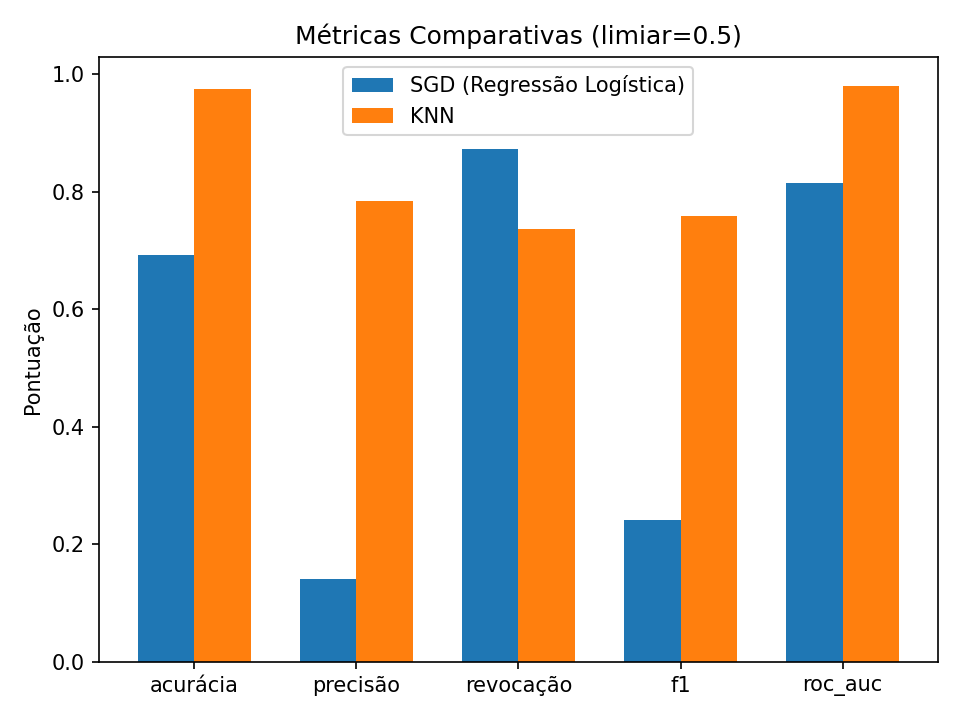

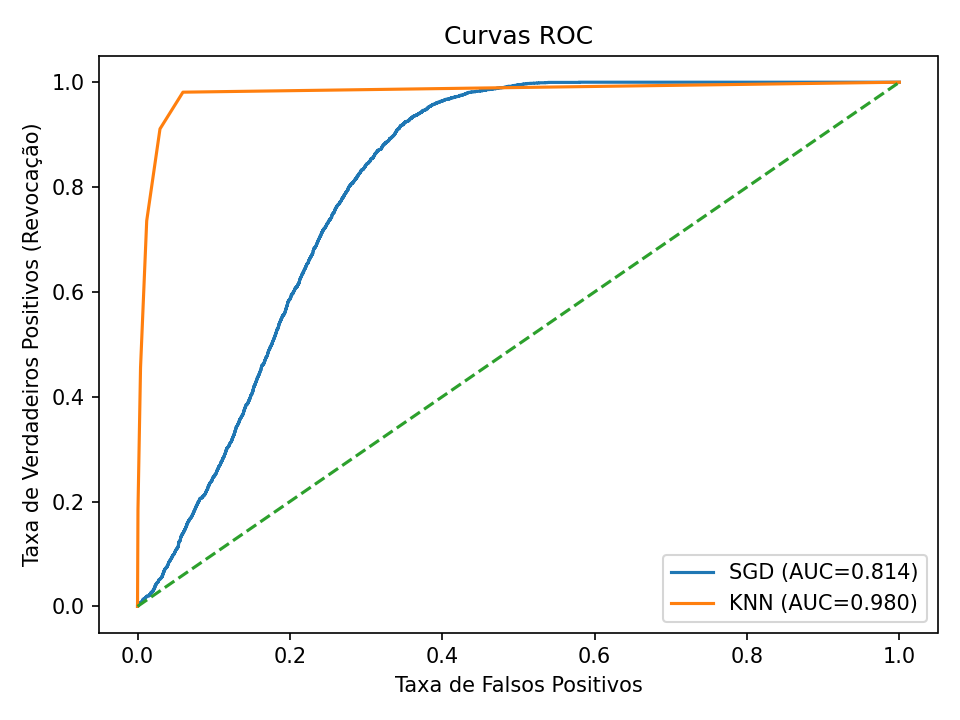

In [ ]:
# Avaliação conjunta e geração de gráficos
with open("data/sgd_results.json","r",encoding="utf-8") as f: sgd_res = json.load(f)
with open("data/knn_results.json","r",encoding="utf-8") as f: knn_res = json.load(f)

# Tabela comparativa (mesmas chaves usadas no JSON)
metricas = ['acurácia','precisão','revocação','f1','roc_auc']
df_cmp = pd.DataFrame({
    "SGD": [sgd_res['metricas_ponto_no_conjunto'][m] for m in metricas],
    "KNN": [knn_res['metricas_ponto_no_conjunto'][m] for m in metricas],
}, index=metricas)
display(df_cmp.style.format('{:.4f}'))

# Gráficos
compare_plots.plot_bar_compare(sgd_res, knn_res, outpath='data/metrics_comparison.png')
compare_plots.plot_roc_both(sgd_res, knn_res, outpath='data/roc_both.png')
display(Image(filename='data/metrics_comparison.png'))
display(Image(filename='data/roc_both.png'))


# Discussão dos resultados
### Análise e Discussão dos Resultados

A análise comparativa dos modelos revelou uma clara superioridade do k-NN para este problema de classificação.

#### Desempenho Geral
O modelo **k-NN demonstrou ser superior em quase todas as métricas**, incluindo acurácia (97,37%), precisão (78,44%), f1-score (75,92%) e AUC (0.980). Em contraste, a Regressão Logística (SGD) obteve um desempenho notavelmente inferior na maioria dessas métricas, embora tenha apresentado uma revocação mais alta.

#### Análise do k-NN
Com a configuração otimizada de **k=5** e utilizando a distância Euclidiana, o k-NN provou ser um classificador não apenas preciso, mas também bem balanceado. Suas métricas de precisão e revocação (73,55%) são equilibradas, o que o torna um modelo robusto e confiável para a aplicação prática de detecção de eventos. A análise da matriz de confusão mostra que ele classificou corretamente a grande maioria das instâncias, com um número baixo de falsos positivos e falsos negativos.

#### Análise da Regressão Logística (SGD)
O modelo de Regressão Logística apresentou um comportamento desequilibrado. Embora tenha alcançado uma **revocação altíssima de 87,18%**, identificando a maioria dos jogos que realmente ocorreram, isso veio ao custo de uma **precisão extremamente baixa de apenas 14,06%**. Na prática, isso significa que o modelo gerou um número excessivo de alarmes falsos (15.129 falsos positivos), o que limita severamente sua utilidade em um cenário real onde o custo de um falso alarme é relevante. O baixo f1-score (24,22%) reflete essa falta de equilíbrio.

#### Conclusão da Análise
A Curva ROC confirma a superioridade do k-NN, que obteve um **AUC de 0.980**, muito próximo do ideal 1.0, indicando uma excelente capacidade de discriminação entre as classes. O SGD, com um AUC de 0.814, embora bom, foi significativamente inferior

Conclui-se que a capacidade do **k-NN de capturar padrões locais e não lineares nos dados foi fundamental para seu sucesso**. A Regressão Logística, por ser um modelo linear, não conseguiu modelar a complexa relação entre o fluxo de tráfego e a ocorrência de jogos com a mesma eficácia.

## Metodologia
 
Nesta seção, detalhamos o processo adotado para comparar algoritmos de classificação supervisionada, com foco em Regressão Logística (SGD) e k-Vizinhos Mais Próximos (k-NN). O objetivo é avaliar o desempenho dos modelos em um conjunto de dados real, utilizando validação rigorosa e métricas variadas.
 
**Algoritmos utilizados:**
- **Regressão Logística (SGDClassifier, loss='log_loss')**: Algoritmo linear, eficiente para grandes volumes de dados e robusto a ruídos. Utiliza gradiente descendente estocástico para otimização.
- **k-Vizinhos Mais Próximos (k-NN)**: Algoritmo não paramétrico que considera a proximidade entre exemplos para realizar a classificação. Foram testados diferentes valores de *k* e métricas de distância para encontrar a melhor configuração.
 
**Engenharia de atributos:**
A partir das variáveis originais `Date` e `Time`, foram extraídos diversos atributos temporais: ano, mês, dia, dia da semana, dia do ano, hora, minuto, minutos desde meia-noite e indicador de fim de semana. O atributo `Count` foi mantido, e o alvo de classificação é o evento `Event` (binário: 0/1).
 
**Validação e métricas:**
Para garantir uma avaliação robusta, foi utilizada **validação cruzada k-fold (k=10)**, permitindo estimativas mais confiáveis do desempenho dos modelos. As métricas reportadas incluem:
- **Acurácia**: Proporção de acertos totais.
- **Precisão**: Proporção de positivos previstos que são realmente positivos.
- **Sensibilidade (Recall)**: Proporção de positivos reais corretamente identificados.
- **F1-score**: Média harmônica entre precisão e recall.
- **ROC e AUC**: Curva ROC e área sob a curva, avaliando a capacidade de separação dos modelos.

## Descrição detalhada dos dados
O conjunto de dados empregado neste estudo é o ”Dodgers Loop Sensor”, proveniente do repositório UCI Machine Learning [Askitis 2010]. O objetivo central é a predicão da ocorrência de jogos de beisebol do time Dodgers com base em anomalias no fluxo de tráfego.

Os dados consistem em medições de contagem de veículos, coletadas por um sensor de laço indutivo localizado em uma rampa de acesso para a rodovia 101 Norte em Los Angeles. As observações foram registradas continuamente ao longo de 25 semanas, com agregações a cada 5 minutos, totalizando 288 medições diárias. O sensor foi estrategicamente posicionado próximo ao estádio, permitindo a captura de um sinal de tráfego sutil — mas não óbvio — que se manifesta principalmente ao final das partidas, quando os espectadores deixam o local.

A princípio, os dados da UCI se mostraram "crus" para o objetivo do trabalho, sendo necessário um tratamento minicioso. Os arquivos e script utilizado para o tratamento dos dados utilizados são descritos a seguir:
##### raw_data/
Pasta com arquivos referentes à base de dados sem qualquer tratamento.
- **Dodgers.data:** conjunto de dados que representa a medição, pelo sensor de loop, de carros passando na rampa de acesso para a Rodovia 101 Norte. As medições contêm data, horário e contagem de carros capturados no momento.
- **Dodgers.event:** conjunto de dados que representa os jogos do Dodgers entre 12/04/2005 e 29/09/2005. Cada linha representa data, horário de início do jogo, horário de fim do jogo, número de torcedores que compareceram ao evento, time adversário e resultado do jogo (Won/Lost e pontuação).
- **Dodgers.name:** explicação geral dos datasets, com informações como número de observações, formatação dos dados e notas importantes.
- **dodgers+loop+sensor.zip:** arquivo zip com todos os datasets iniciais.

##### Dodgers_data.csv
CSV com os dados de Dodgers.data devidamente tratados. Foi utilizado como base para a criação do arquivo de dados principal *(Dodgers_processed.csv)*.

##### Dodgers_events.csv
CSV com os dados de Dodgers.events tratados. Foi utilizado para monitorar o desempenho dos modelos, comparando as medições marcadas como evento (1) com os jogos presentes no arquivo. 

##### Dodgers_processed.csv
Dataset principal do projeto. De modo geral, é constituído pelo arquivo Dodger_data.csv com um coluna extra, marcando as medições realizadas (1) ou não (0) durante a ocorrência de um jogo do Dodgers.

##### process_data.py
Script de tratamento dos dados. As alterações principais realizadas foram:
1. Tratamento de valores -1 para a contagem de carros. Para resolver isso, foi feita a média aritmética dos 4 valores válidos mais próximos.
2. Adição da coluna booleana 'Event', simbolizando se tal medição foi feita durante a duração de um jogo ou não.  

## Execução dos scripts
 
- `sgd_logreg.py`: executa a análise com regressão logística (SGD)
- `knn_model.py`: executa a análise com KNN (grid reduzido)
- `test_models.py`: executa ambos e salva os resultados em JSON
- `compare_plots.py`: gera gráficos comparativos (barras e ROC)
 
Os dados gerados ficam em `data/`.

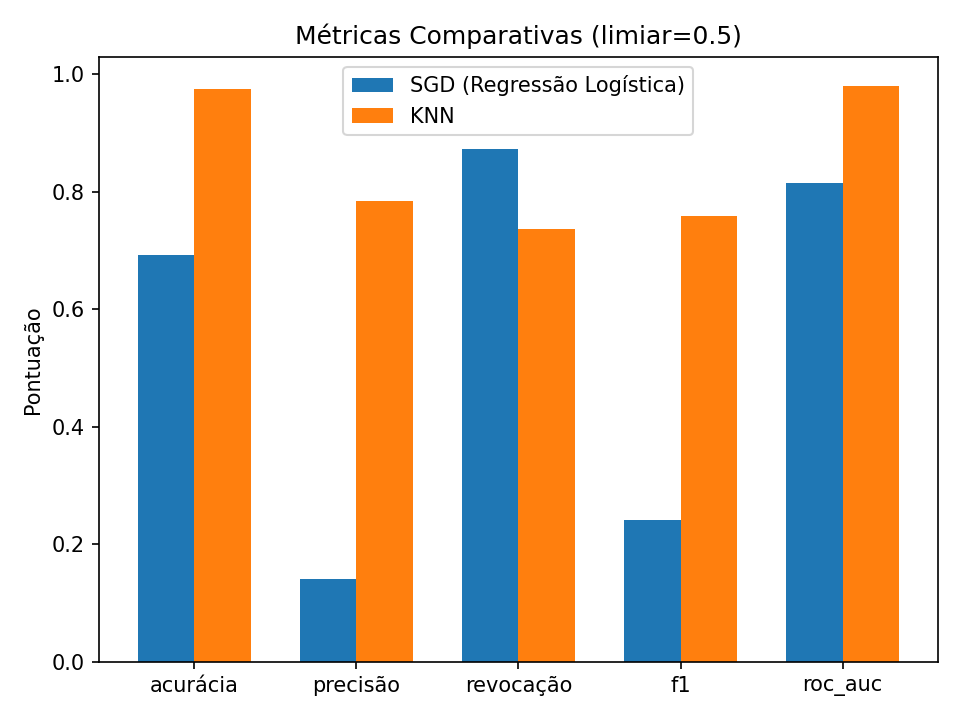

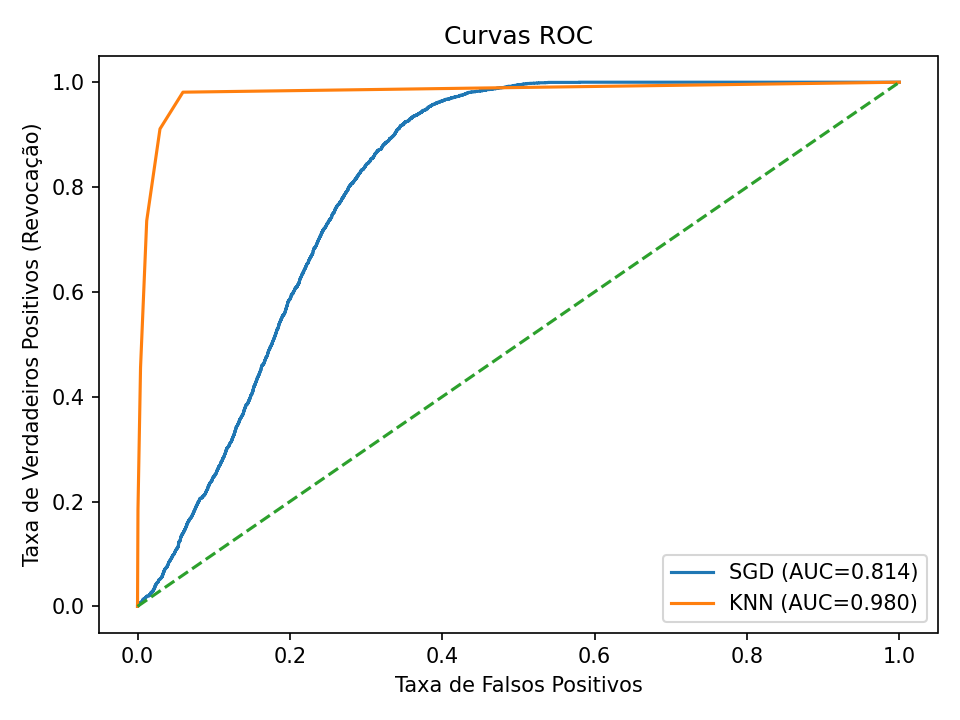

In [8]:
import os
if os.path.exists('data/metrics_comparison.png'):
    display(Image(filename='data/metrics_comparison.png'))
if os.path.exists('data/roc_both.png'):
    display(Image(filename='data/roc_both.png'))


,SGD (Regressão Logística),KNN
acurácia,0.6926,0.9737
precisão,0.1406,0.7845
revocação,0.8718,0.7356
f1,0.2422,0.7592
roc_auc,0.8145,0.9802


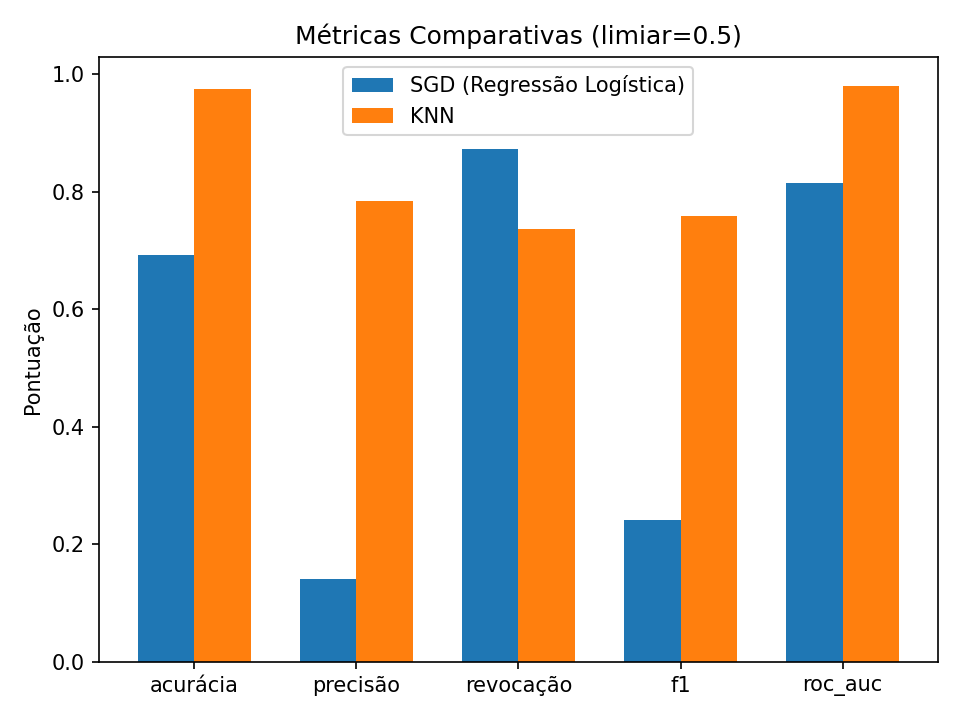

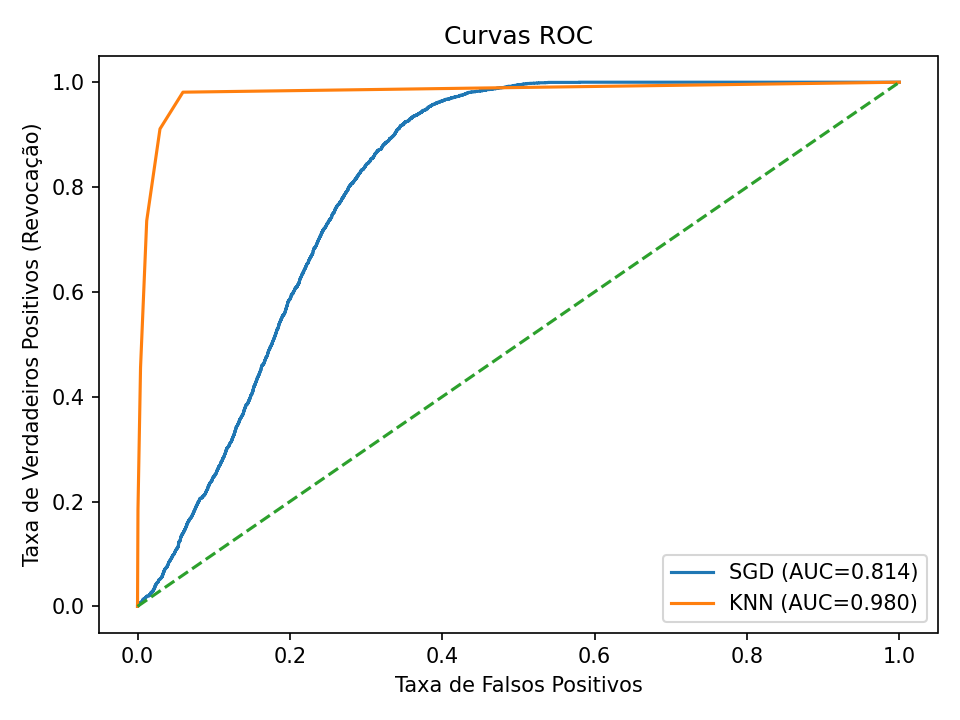

In [ ]:
# Carrega e exibe a comparação dos resultados dos modelos
import json, pandas as pd
from IPython.display import Image, display
with open('data/sgd_results.json','r',encoding='utf-8') as f: sgd=json.load(f)
with open('data/knn_results.json','r',encoding='utf-8') as f: knn=json.load(f)
metricas=['acurácia','precisão','revocação','f1','roc_auc']
df=pd.DataFrame({
    'SGD':[sgd['metricas_ponto_no_conjunto'][m] for m in metricas],
    'KNN':[knn['metricas_ponto_no_conjunto'][m] for m in metricas]
}, index=metricas)
display(df.style.format('{:.4f}'))
display(Image(filename='data/metrics_comparison.png'))
display(Image(filename='data/roc_both.png'))
